In [1]:
# Install a pip comtradeapicall package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install --upgrade comtradeapicall

In [2]:
# Install a pip pandas package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas

In [3]:
# Install a pip matplotlib package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install matplotlib

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import comtradeapicall

In [5]:
subscription_key = "b5856aa064474537a609f9c773a9441d"

This is an experimental-data section. The estimates presented here are provisional, and not official statistics. Please cite these estimates as: Cerdeiro, Komaromi, Liu and Saeed (2020) [https://www.imf.org/en/Publications/WP/Issues/2020/05/14/World-Seaborne-Trade-in-Real-Time-A-Proof-of-Concept-for-Building-AIS-based-Nowcasts-from-49393]; AIS data collected by MarineTraffic; available at UN COMTRADE API. When consuming the data, users should understand its limitation. For a complete description of the methodology, please consult the paper, especially Sections I and VI.

In [6]:
#show description of the data variable including disclaimer
comtradeapicall.getReference('ais:dataitems')

,dataItem,description
0,disclaimer,This is an experimental-data section. The esti...
1,typeCode,Product type: Goods or Services
2,freqCode,The time interval at which observations occur
3,date,The date to which the measured observation is ...
4,countryareaCode,The country or geographic area to which the me...
5,countryareaDesc,Description of the country or geographic area
6,vesselTypeCode,The high level categorization of vessels trans...
7,vesselTypeDescription,Description of vessel types
8,flowCode,Trade flow (exports/imports)
9,flowDesc,Description of trade flows


In [7]:
#get list of vessel types
comtradeapicall.getReference('ais:vesseltypes')

,id,text,vesselTypeCode,vesselTypeDesc
0,0,Total,0,Total
1,1,Bulk,1,Bulk
2,2,Container/general cargo,2,Container/general cargo
3,3,Oil/chemicals,3,Oil/chemicals
4,4,Oil/chemicals bunker/movement,4,Oil/chemicals bunker/movement
5,5,Vehicles,5,Vehicles
6,6,LPG/LNG,6,LPG/LNG
7,7,Foodstuff,7,Foodstuff


In [ ]:
country_df = pd.read_csv("data/country_codes_V202501.csv")

# Normalize names to lowercase
country_df['country_name'] = country_df['country_name'].str.lower()

def get_country_code(name):
    name = name.lower().strip()
    match = country_df[country_df['country_name'] == name]
    if not match.empty:
        return int(match['country_code'].values[0])
    else:
        suggested_names = country_df[country_df['country_name'].str[:3] == name[:3]]
        if not suggested_names.empty:
            suggestions = ', '.join(suggested_names['country_name'].values)
            raise ValueError(f"Country '{name}' not found. Did you mean: {suggestions}?")
        else:
            raise ValueError(f"Country '{name}' not found in country codes.")



246

In [37]:
# Get number of port calls and trade volume estimates derrived from AIS data for Ukraine in 2020-2023 with vessel types DRY BULK.
df_aistrade = comtradeapicall.getAIS(subscription_key, countryareaCode=get_country_code('portugal'), vesselTypeCode='1', dateFrom='2020-01-01', dateTo='2023-12-31')

In [38]:
df_aistrade.head(5)

,typeCode,freqCode,countryareaCode,countryareaDesc,vesselTypeCode,vesselTypeDesc,flowCode,flowDesc,date,num_pc,mtc,dwt,num_pc_ma,mtc_ma,dwt_ma
0,C,D,620,Portugal,1,Bulk,M,Imports,2020-01-01T00:00:00,1.0,0.0,27174.0,0.833,7580.012,31664.900
1,C,D,620,Portugal,1,Bulk,M,Imports,2020-01-02T00:00:00,3.0,54232.2,99082.0,0.933,9387.754,34967.633
2,C,D,620,Portugal,1,Bulk,M,Imports,2020-01-03T00:00:00,0.0,0.0,0.0,0.900,9342.483,33076.467
3,C,D,620,Portugal,1,Bulk,M,Imports,2020-01-04T00:00:00,0.0,0.0,0.0,0.867,7822.439,31277.167
4,C,D,620,Portugal,1,Bulk,M,Imports,2020-01-05T00:00:00,0.0,0.0,0.0,0.867,7822.439,31277.167


Text(0.5, 1.0, 'Trade Volume Distribution')

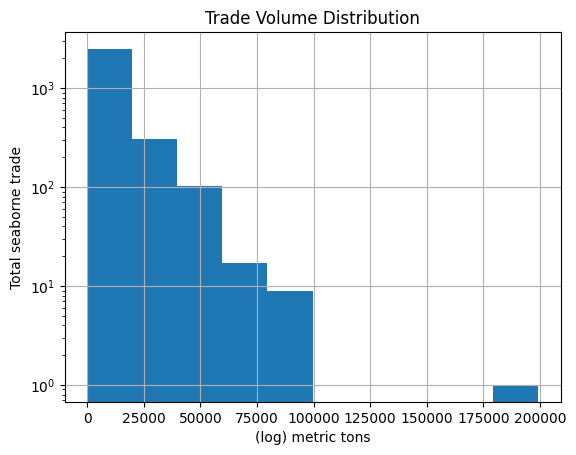

In [39]:
# plot the mtc (trade volume in metric tons) histogram - in log scale
df_aistrade.hist("mtc", log=True);
plt.xlabel('(log) metric tons')
plt.ylabel('Total seaborne trade')
plt.title('Trade Volume Distribution')

In [40]:
#change to date format, and add year_month column
df_aistrade["date"] = pd.to_datetime(df_aistrade["date"]) # Convert Date column to datetime format
df_aistrade["year_month"] = df_aistrade["date"].dt.to_period("M")
df_aistrade["month"] = df_aistrade["date"].dt.strftime('%m') + '(' + df_aistrade["date"].dt.strftime('%b') +')'
df_aistrade["year"] = df_aistrade["date"].dt.year

In [41]:
#preparing for plotting
df_aistrade_group = df_aistrade.groupby(['year', 'month']).agg({'mtc': ['sum', 'min', 'max']})
df_aistrade_group.columns = ['mtc_sum', 'mtc_min', 'mtc_max']
df_aistrade_group = df_aistrade_group.reset_index()
df_aistrade_pivot = df_aistrade_group.pivot(index='month', columns='year')['mtc_sum']

Text(0.5, 0, 'Month')

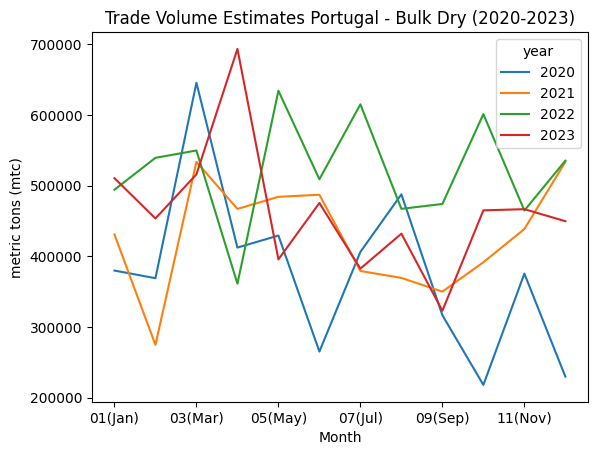

In [47]:
#plot the data to show year-to-year trade volume in Ukraine
df_aistrade_pivot.plot()
plt.title(f'Trade Volume Estimates {df_aistrade["countryareaDesc"][1]} - Bulk Dry (2020-2023)')
plt.ylabel('metric tons (mtc)')
plt.xlabel('Month')